# DA逻辑循环跳转功能测试

In [1]:
from datetime import time
from DAboard import *
from IPython.display import Image
import matplotlib.pyplot as plt
import logging

In [2]:
#setup
logger = logging.getLogger()
logger.setLevel(logging.DEBUG)

## 准备序列
### 一级触发输出开始单元

In [3]:
ctrl = 0x1 << 11
loop_cnt = 2
loop_level = 0
seq_L1 =  [loop_level,0,loop_cnt,ctrl]
seq_L1

[0, 0, 2, 2048]

### 一级触发输出停止单元

In [4]:
ctrl = 0x2 << 11
jump_addr = 1
loop_level = 0
seq_J1 =  [loop_level,0,jump_addr,ctrl]
seq_J1

[0, 0, 1, 4096]

### 二级触发输出开始单元

In [5]:
ctrl = 0x1 << 11
loop_cnt = 3
loop_level = 1
seq_L2 =  [loop_level,0,loop_cnt,ctrl]
loop_cnt = 10
seq_L2_nomal =  [loop_level,0,loop_cnt,ctrl]

### 二级触发输出停止单元

In [6]:
ctrl = 0x2 << 11
jump_addr = 2
loop_level = 1
seq_J2 =  [loop_level,0,jump_addr,ctrl]
seq_J2

[1, 0, 2, 4096]

### 三级触发输出开始单元

In [7]:
ctrl = 0x1 << 11
loop_cnt = 2
loop_level = 2
seq_L3 =  [loop_level,0,loop_cnt,ctrl]
loop_cnt = 10
seq_L3_nomal =  [loop_level,0,loop_cnt,ctrl]

### 三级触发输出停止单元

In [8]:
ctrl = 0x2 << 11
jump_addr = 3
loop_level = 2
seq_J3 =  [loop_level,0,jump_addr,ctrl]
seq_J3

[2, 0, 3, 4096]

### 四级触发输出开始单元

In [9]:
ctrl = 0x1 << 11
loop_cnt = 3
loop_level = 3
seq_L4 =  [loop_level,0,loop_cnt,ctrl]
seq_L4

[3, 0, 3, 2048]

### 四级触发输出停止单元

In [10]:
ctrl = 0x2 << 11
jump_addr = 8
loop_level = 3
seq_J4 =  [loop_level,0,jump_addr,ctrl]
seq_J4

[3, 0, 8, 4096]

### 触发单元 正弦 周期为16个采样点

In [11]:
#触发类型，地址为0，长度为64ns ， 重复次数为0
ctrl = 0x8 << 11
start_addr = 0
length = 16
seq_T =  [start_addr,length,0,ctrl]
seq_T

[0, 16, 0, 16384]

### 计时输出单元  正弦波（周期为128个采样点）

In [12]:
#计时输出类型，地址为16，长度为128ns 计时2ns
ctrl = 0x4 << 11
start_addr = 16
length = 32
seq_D =  [start_addr,length,2,ctrl]
seq_D

[16, 32, 2, 8192]

### 态判断输出单元

In [13]:
ctrl = 0xC << 11
start_addr1 = 1#1态
start_addr2 = 1#2态
start_addr3 = 1#NULL态
start_addr4 = 1#0态
seq_C =  [start_addr1<<8 | start_addr2,64,start_addr3<<8 | start_addr4,ctrl]
seq_C

[257, 64, 257, 24576]

### 停止序列

In [14]:
seq_T_stop=[0,16,2,seq_D[3]|(1<<15)]

## 准备波形
### 波形区说明
0-15地址为16x4=64ns的正弦波（周期为16个采样点）    触发  
16-47地址为32x4=128ns的正弦波（周期为256个采样点） 计数  
48-127地址为80x4=320ns的方波（周期为640个采样点）  
触发序列收到触发时输出0-31的波形：seq_T=[0, 16, 0, 16384]  
计数序列输出32-63地址的正弦波： seq_D=[16, 32, 2, 8192]  
态判断输出0态时输出64-95地址的波形，1态时输出64-95地址的波形。seq_C=[258, 64, 769, 24576]


In [15]:
da_ctrl = waveform()
da_ctrl.generate_sin(repeat=10,cycle_count=16)
# da_ctrl.generate_seq(length=len(da_ctrl.wave)>>4)
# da_ctrl.gen_comp_wave()
# count_seq = [0, 64, 2, 4<<11]*2
tmp_wave = da_ctrl.wave[0:128]
da_ctrl.generate_sin(repeat=3,cycle_count=256)
tmp_wave += da_ctrl.wave[0:256]
# da_ctrl.generate_cos(repeat=3,cycle_count=256)
da_ctrl.generate_squr(repeat=4, hightime=320,lowtime1=160,lowtime2=160)
tmp_wave += da_ctrl.wave[0:640]
da_ctrl.wave = tmp_wave

### 基础波形

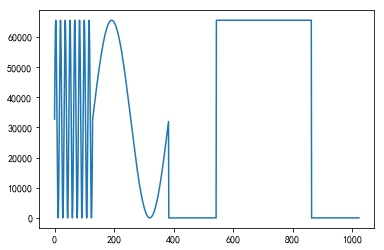

In [16]:
plt.figure()
plt.plot(da_ctrl.wave)
plt.show()

## 准备DA

In [17]:
from DAboard import *
da = DABoard()
ip = '10.0.5.5'

Calling Board_Defines class constructor


In [18]:
da.connect(ip)
da.SetLoop(1,1,1,1)
da.SetDefaultVolt(1,32768)
da.SetDefaultVolt(2,32768)
da.SetDefaultVolt(3,32768)
da.SetDefaultVolt(4,32768)
da.StartStop(240) #停止所有输出
for i in range(1,5): #4个通道均写入基础波形
    da.WriteWave(i,da_ctrl.wave)

Host name is: 10.0.5.5
connected
default volt32767
default volt32767
default volt32767
default volt32767


## 准备触发

In [19]:
da.MultiBoardMode(1) #1是单板工作
da.SetTrigCount(1)
da.SetTrigCountL2(1)
da.SetTrigInterval(200*250)#200us触发间隔
da.SetTrigIntervalL2(200*250)#200us触发间隔
da.SetTrigStart(52) 
da.SetDACStart(1)

## 准备示波器

In [20]:
## %matplotlib notebook
import matplotlib.pyplot as plt
import qcodes as qc
from qcodes.instrument_drivers.rohde_schwarz.RTO1000 import RTO1000

### 示波器地址 

In [21]:
rto = RTO1000('rto', 'TCPIP0::10.0.0.230::inst0::INSTR')

Connected to: Rohde&Schwarz RTO (serial:1329.7002k14/300087, firmware:3.65.1.0) in 0.22s


复位示波器，进入初始设置

In [22]:
rto.reset()
rto.display('view')

### 使能连接信号的通道  

In [23]:
rto.ch3.coupling('DC')  # 'DC' means DC 50 Ohm, 'DCLimit' means DC 1 MOhm, 'AC' means AC 1 MOhm.
rto.ch3.state('ON')
# This is EXACTLY matching the waveform...
rto.ch3.range(2)
rto.ch3.offset(0.3)

In [24]:
rto.ch1.coupling('DC')  # 'DC' means DC 50 Ohm, 'DCLimit' means DC 1 MOhm, 'AC' means AC 1 MOhm.
rto.ch1.state('ON')
# This is EXACTLY matching the waveform...
ch1_range = 2
rto.ch1.range(ch1_range)
rto.ch1.offset(-0.3)

### 设置示波器显示  
设置通道在屏幕的偏移位置  
设置时间尺度  
设置电压尺度  

In [25]:
rto.timebase_range(1/100e3)
rto.timebase_position(5e-6)

### 设置示波器触发   
设置触发通道  
设置触发电平  
设置触发显示位置  
示波器进入等待触发状态   

In [26]:
rto.trigger_source('CH1')
rto.trigger_type('EDGE')
rto.trigger_edge_slope('POS')
rto.trigger_level(0.5)
rto.trigger_mode('NORM')

## 波形输出与读回对比测试

### DA发出的波形数据与示波器采集回的数据进行归一化的叠加显示函数

In [27]:
import numpy as np

def process_waves(wave, osc_data):
    wave_data = np.asarray(wave)

    wave_data = wave_data[64:-1]
    space = wave_data.max()-wave_data.min()
    min_val = wave_data.min()
    wave_data = (wave_data-min_val)/space
    length = len(wave)-64

    osc_data = osc_data[::5,]
    osc_data = osc_data[16:16+length-1,]
    space = osc_data.max()-osc_data.min()
    min_val = osc_data.min()
    osc_data = (osc_data-min_val)/space
    # da.disconnect()
    plot = qc.MatPlot(subplots=1)
    plot[0].add(wave_data,xlabel="采样点", xunit="(5e-10)",\
                ylabel= "归一化显示电压值",yunit ="V")
    plot[0].add(osc_data,xlabel="采样点", xunit="(5e-10)",\
                ylabel= "归一化显示电压值",yunit ="V")

### 无嵌套

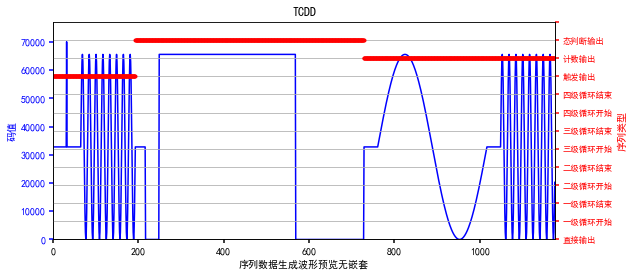

In [28]:
da_ctrl.seq = seq_T+seq_C+seq_D+seq_T_stop+[0,0,0,0]*10
sample_count,wave = da_ctrl.wave_preview('无嵌套')

设置通道在屏幕的偏移位置  
设置时间尺度

In [29]:
duration = int((sample_count+199)/200) * 10e-8
rto.timebase_range(duration) 
rto.timebase_position(duration/2 - 10e-9)

# avg_cnt = 2
# rto.high_definition_state('ON')  # 'ON' -> 16 bit, 'OFF' -> 8 bit
# rto.num_acquisitions(avg_cnt)
# rto.ch3.arithmetics('AVERAGE')  # other options: 'ENVELOPE' and 'OFF'
# rto.ch1.arithmetics('AVERAGE')  # other options: 'ENVELOPE' and 'OFF'
rto.run_single()  # and perform a single run. 
rto.run_cont()  # and perform a single run. 
time.sleep(1)

设置新的序列数据
发出新序列数据对应的波形

In [30]:
for i in range(1,5):
    da.WriteSeq(i,da_ctrl.seq)

# da.SetTrigCount(avg_cnt)
# da.SetLoop(avg_cnt,avg_cnt,avg_cnt,avg_cnt)
da.StartStop(15)

da.SendIntTrig()
# Next, the trace must be prepared. This ensures that all settings are correct

DataSet:
   location = 'data/2018-09-17/#399_{name}_18-23-03'
   <Type>   | <array_id> | <array.name> | <array.shape>
   Measured | trace      | trace        | (6000,)
acquired at 2018-09-17 18:23:03
DataSet:
   location = 'data/2018-09-17/#400_{name}_18-23-03'
   <Type>   | <array_id> | <array.name> | <array.shape>
   Measured | trace      | trace        | (6000,)
acquired at 2018-09-17 18:23:03


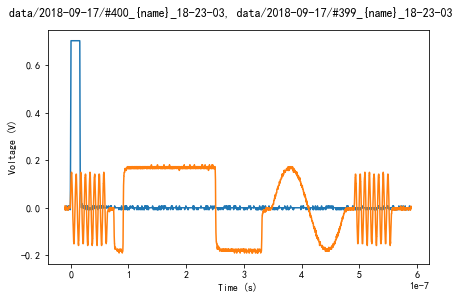

In [31]:
rto.ch3.trace.prepare_trace()
rto.ch1.trace.prepare_trace()
# Now make a measurement of the trace and display it
data_tr3 = qc.Measure(rto.ch3.trace).run()
data_tr1 = qc.Measure(rto.ch1.trace).run()

plot = qc.MatPlot(subplots=1)
plot[0].add(data_tr1.arrays['trace'])
plot[0].add(data_tr3.arrays['trace'])
time.sleep(2)

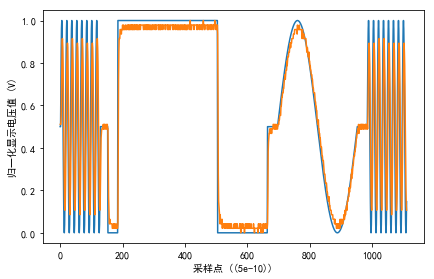

In [32]:
process_waves(wave, data_tr3.arrays['trace'])

读取示波器波形数据并画图

### 一层嵌套

0层循环起始：地址：1
0层循环结束：跳转：1


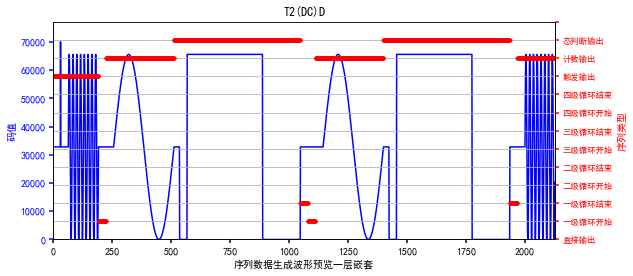

In [33]:
da_ctrl.seq = seq_T+seq_L1+seq_D+seq_C+seq_J1+seq_T_stop+[0,0,0,0]*4
sample_count,wave = da_ctrl.wave_preview('一层嵌套')

In [34]:
duration = int((sample_count+199)/200) * 10e-8
rto.timebase_range(duration) 
rto.timebase_position(duration/2 - 10e-9)

rto.run_single()  # and perform a single run.
time.sleep(1) 

设置新的序列数据
发出新序列数据对应的波形

In [35]:
for i in range(1,5):
    da.WriteSeq(i,da_ctrl.seq)

da.StartStop(15)

da.SendIntTrig()

读取示波器波形数据并画图

DataSet:
   location = 'data/2018-09-17/#401_{name}_18-23-07'
   <Type>   | <array_id> | <array.name> | <array.shape>
   Measured | trace      | trace        | (11000,)
acquired at 2018-09-17 18:23:07
DataSet:
   location = 'data/2018-09-17/#402_{name}_18-23-07'
   <Type>   | <array_id> | <array.name> | <array.shape>
   Measured | trace      | trace        | (11000,)
acquired at 2018-09-17 18:23:07


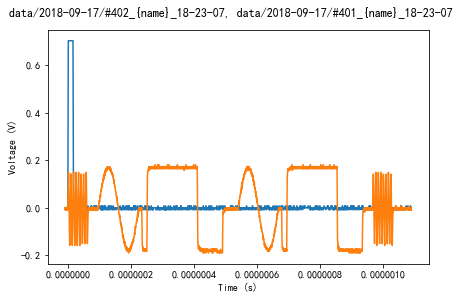

In [36]:
# Next, the trace must be prepared. This ensures that all settings are correct
rto.ch3.trace.prepare_trace()
rto.ch1.trace.prepare_trace()
# Now make a measurement of the trace and display it
data_tr3 = qc.Measure(rto.ch3.trace).run()
data_tr1 = qc.Measure(rto.ch1.trace).run()

plot = qc.MatPlot(subplots=1)
plot[0].add(data_tr1.arrays['trace'])
plot[0].add(data_tr3.arrays['trace'])

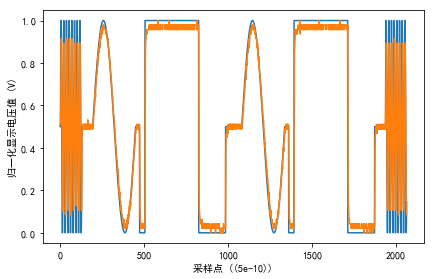

In [37]:
process_waves(wave, data_tr3.arrays['trace'])

### 两层嵌套

0层循环起始：地址：1
1层循环起始：地址：2
1层循环结束：跳转：2
0层循环结束：跳转：1


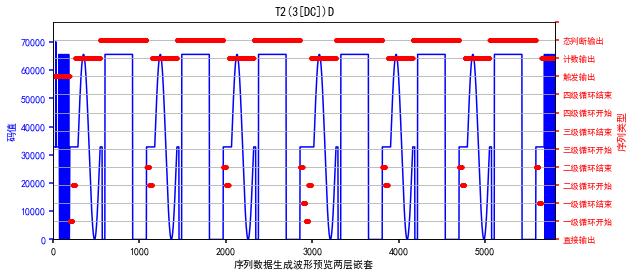

In [38]:
da_ctrl.seq = seq_T+seq_L1+seq_L2+seq_D+seq_C+seq_J2+seq_J1+seq_T_stop+[0,0,0,0]*10
sample_count,wave = da_ctrl.wave_preview('两层嵌套')

In [39]:
duration = (int(sample_count+40) >> 1) * 10e-10
rto.timebase_range(duration) 
rto.timebase_position(duration/2 - 10e-9)

rto.run_single()  # and perform a single run.
time.sleep(1) 

设置新的序列数据
发出新序列数据对应的波形

In [40]:
for i in range(1,5):
    da.WriteSeq(i,da_ctrl.seq)

da.StartStop(15)

da.SendIntTrig()

读取示波器波形数据并画图

DataSet:
   location = 'data/2018-09-17/#403_{name}_18-23-08'
   <Type>   | <array_id> | <array.name> | <array.shape>
   Measured | trace      | trace        | (29240,)
acquired at 2018-09-17 18:23:09
DataSet:
   location = 'data/2018-09-17/#404_{name}_18-23-09'
   <Type>   | <array_id> | <array.name> | <array.shape>
   Measured | trace      | trace        | (29240,)
acquired at 2018-09-17 18:23:09


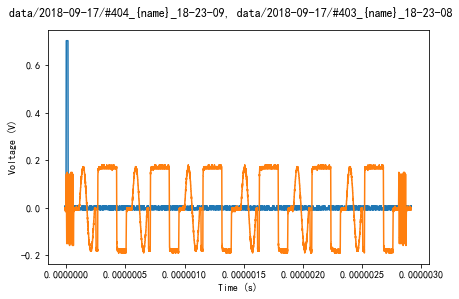

In [41]:
# Next, the trace must be prepared. This ensures that all settings are correct
rto.ch3.trace.prepare_trace()
rto.ch1.trace.prepare_trace()
# Now make a measurement of the trace and display it
data_tr3 = qc.Measure(rto.ch3.trace).run()
data_tr1 = qc.Measure(rto.ch1.trace).run()

plot = qc.MatPlot(subplots=1)
plot[0].add(data_tr1.arrays['trace'])
plot[0].add(data_tr3.arrays['trace'])

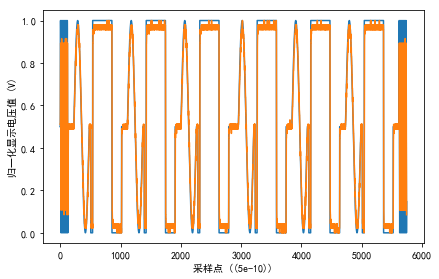

In [42]:
process_waves(wave, data_tr3.arrays['trace'])

### 三层嵌套  

0层循环起始：地址：1
1层循环起始：地址：2
2层循环起始：地址：3
2层循环结束：跳转：3
1层循环结束：跳转：2
0层循环结束：跳转：1


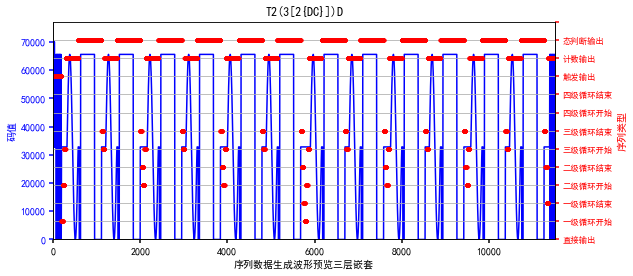

In [43]:
da_ctrl.seq = seq_T+seq_L1+seq_L2+seq_L3+seq_D+seq_C+seq_J3+seq_J2+seq_J1+\
seq_T_stop+[0,0,0,0]*10
sample_count,wave = da_ctrl.wave_preview('三层嵌套')

In [44]:
duration = (int(sample_count+40) >> 1) * 10e-10
rto.timebase_range(duration) 
rto.timebase_position(duration/2 - 10e-9)

rto.run_single()  # and perform a single run. 
time.sleep(1)

sample_count

11521

设置新的序列数据
发出新序列数据对应的波形

In [45]:
da.StartStop(240)
for i in range(1,5):
    da.WriteSeq(i,da_ctrl.seq)

da.StartStop(15)

da.SendIntTrig()

读取示波器波形数据并画图

DataSet:
   location = 'data/2018-09-17/#405_{name}_18-23-11'
   <Type>   | <array_id> | <array.name> | <array.shape>
   Measured | trace      | trace        | (57800,)
acquired at 2018-09-17 18:23:11
DataSet:
   location = 'data/2018-09-17/#406_{name}_18-23-11'
   <Type>   | <array_id> | <array.name> | <array.shape>
   Measured | trace      | trace        | (57800,)
acquired at 2018-09-17 18:23:12


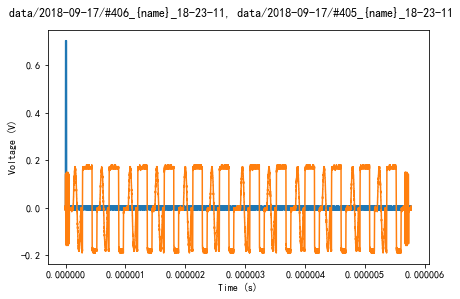

In [46]:
# Next, the trace must be prepared. This ensures that all settings are correct
rto.ch3.trace.prepare_trace()
rto.ch1.trace.prepare_trace()
# Now make a measurement of the trace and display it
data_tr3 = qc.Measure(rto.ch3.trace).run()
data_tr1 = qc.Measure(rto.ch1.trace).run()

plot = qc.MatPlot(subplots=1)
plot[0].add(data_tr1.arrays['trace'])
plot[0].add(data_tr3.arrays['trace'])

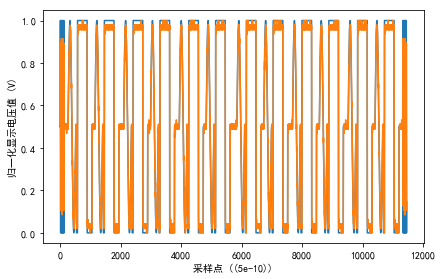

In [47]:
process_waves(wave, data_tr3.arrays['trace'])

### 四层嵌套  

0层循环起始：地址：1
1层循环起始：地址：2
2层循环起始：地址：3
3层循环起始：地址：4
3层循环结束：跳转：4
2层循环结束：跳转：3
1层循环结束：跳转：2
0层循环结束：跳转：1


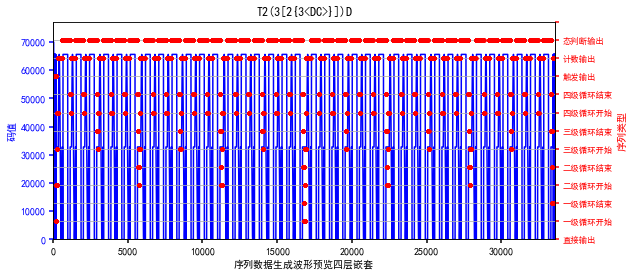

In [48]:
da_ctrl.seq = seq_T+seq_L1+seq_L2+seq_L3+seq_L4+seq_D+seq_C+seq_J4+seq_J3+\
seq_J2+seq_J1+seq_T_stop+[0,0,0,0]*10
sample_count,wave = da_ctrl.wave_preview('四层嵌套')

In [49]:
duration = (int(sample_count+40) >> 1) * 10e-10
rto.timebase_range(duration) 
rto.timebase_position(duration/2 - 10e-9)

rto.run_single()  # and perform a single run. 
time.sleep(1)

设置新的序列数据
发出新序列数据对应的波形

In [50]:
for i in range(1,5):
    da.WriteSeq(i,da_ctrl.seq)

da.StartStop(15)

da.SendIntTrig()

读取示波器波形数据并画图

DataSet:
   location = 'data/2018-09-17/#407_{name}_18-23-13'
   <Type>   | <array_id> | <array.name> | <array.shape>
   Measured | trace      | trace        | (168200,)
acquired at 2018-09-17 18:23:15
DataSet:
   location = 'data/2018-09-17/#408_{name}_18-23-15'
   <Type>   | <array_id> | <array.name> | <array.shape>
   Measured | trace      | trace        | (168200,)
acquired at 2018-09-17 18:23:17


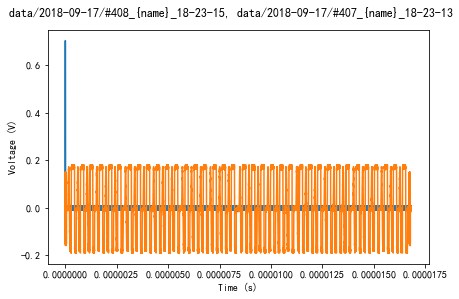

In [51]:
# Next, the trace must be prepared. This ensures that all settings are correct
rto.ch3.trace.prepare_trace()
rto.ch1.trace.prepare_trace()
# Now make a measurement of the trace and display it
data_tr3 = qc.Measure(rto.ch3.trace).run()
data_tr1 = qc.Measure(rto.ch1.trace).run()

plot = qc.MatPlot(subplots=1)
plot[0].add(data_tr1.arrays['trace'])
plot[0].add(data_tr3.arrays['trace'])
time.sleep(3)



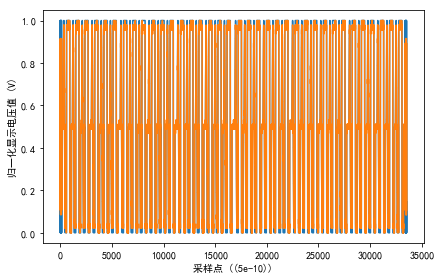

In [52]:
process_waves(wave, data_tr3.arrays['trace'])

### 三层嵌套2&3  

0层循环起始：地址：1
1层循环起始：地址：2
2层循环起始：地址：3
2层循环结束：跳转：3
1层循环结束：跳转：2
3层循环起始：地址：8
3层循环结束：跳转：8
0层循环结束：跳转：1


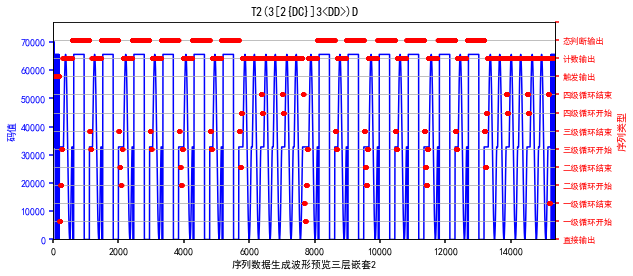

In [53]:
da_ctrl.seq = seq_T+seq_L1+seq_L2+seq_L3+seq_D+seq_C+seq_J3+seq_J2+seq_L4+\
seq_D*2+seq_J4+seq_J1+seq_T_stop+[0,0,0,0]*10 
sample_count,wave = da_ctrl.wave_preview('三层嵌套2')

In [54]:

duration = (int(sample_count+40) >> 1) * 10e-10
rto.timebase_range(duration) 
rto.timebase_position(duration/2 - 10e-9)
rto.timebase_range(duration) 
rto.timebase_position(duration/2 - 10e-9)

rto.run_single()  # and perform a single run. 
time.sleep(1)

sample_count

15361

设置新的序列数据
发出新序列数据对应的波形

In [55]:
for i in range(1,5):
    da.WriteSeq(i,da_ctrl.seq)

da.StartStop(15)

da.SendIntTrig()

读取示波器波形数据并画图

DataSet:
   location = 'data/2018-09-17/#409_{name}_18-23-22'
   <Type>   | <array_id> | <array.name> | <array.shape>
   Measured | trace      | trace        | (77000,)
acquired at 2018-09-17 18:23:22
DataSet:
   location = 'data/2018-09-17/#410_{name}_18-23-22'
   <Type>   | <array_id> | <array.name> | <array.shape>
   Measured | trace      | trace        | (77000,)
acquired at 2018-09-17 18:23:23


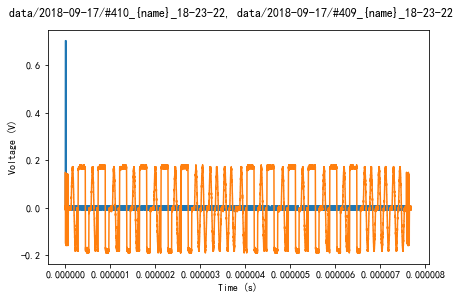

In [56]:
# Next, the trace must be prepared. This ensures that all settings are correct
rto.ch3.trace.prepare_trace()
rto.ch1.trace.prepare_trace()
# Now make a measurement of the trace and display it
data_tr3 = qc.Measure(rto.ch3.trace).run()
data_tr1 = qc.Measure(rto.ch1.trace).run()

plot = qc.MatPlot(subplots=1)
plot[0].add(data_tr1.arrays['trace'])
plot[0].add(data_tr3.arrays['trace'])

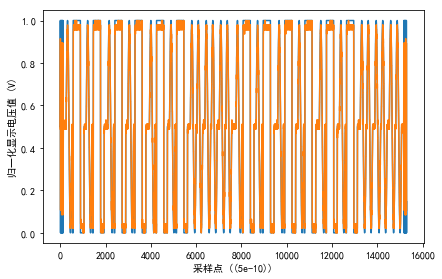

In [57]:
process_waves(wave, data_tr3.arrays['trace'])

0层循环起始：地址：1
1层循环起始：地址：2
2层循环起始：地址：3
2层循环结束：跳转：3
1层循环结束：跳转：2
1层循环起始：地址：8
1层循环结束：跳转：8
0层循环结束：跳转：1


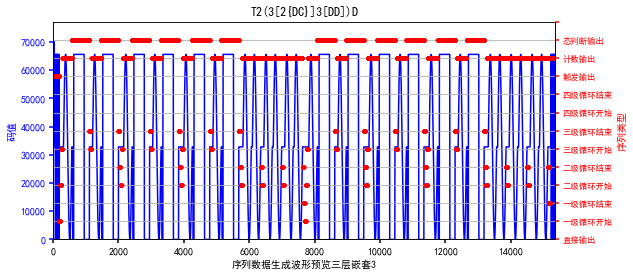

In [58]:
da_ctrl.seq = seq_T+seq_L1+seq_L2+seq_L3+seq_D+seq_C+seq_J3+seq_J2+seq_L2+\
seq_D*2+seq_J2+seq_J1+seq_T_stop+[0,0,0,0]*4
sample_count,wave = da_ctrl.wave_preview('三层嵌套3')

In [59]:
duration = (int(sample_count+40) >> 1) * 10e-10
rto.timebase_range(duration) 
rto.timebase_position(duration/2 - 10e-9)

rto.run_single()  # and perform a single run. 
time.sleep(1)

设置新的序列数据
发出新序列数据对应的波形

In [60]:
for i in range(1,5):
    da.WriteSeq(i,da_ctrl.seq)

da.StartStop(15)

da.SendIntTrig()

读取示波器波形数据并画图

DataSet:
   location = 'data/2018-09-17/#411_{name}_18-23-25'
   <Type>   | <array_id> | <array.name> | <array.shape>
   Measured | trace      | trace        | (77000,)
acquired at 2018-09-17 18:23:26
DataSet:
   location = 'data/2018-09-17/#412_{name}_18-23-26'
   <Type>   | <array_id> | <array.name> | <array.shape>
   Measured | trace      | trace        | (77000,)
acquired at 2018-09-17 18:23:26


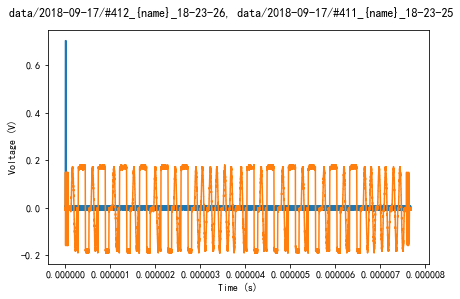

In [61]:
# Next, the trace must be prepared. This ensures that all settings are correct
rto.ch3.trace.prepare_trace()
rto.ch1.trace.prepare_trace()
# Now make a measurement of the trace and display it
data_tr3 = qc.Measure(rto.ch3.trace).run()
data_tr1 = qc.Measure(rto.ch1.trace).run()

plot = qc.MatPlot(subplots=1)
plot[0].add(data_tr1.arrays['trace'])
plot[0].add(data_tr3.arrays['trace'])

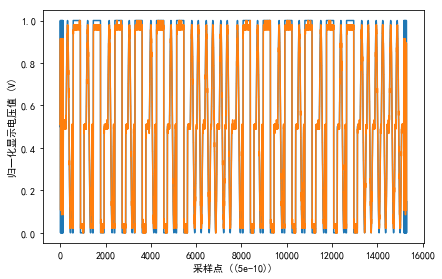

In [62]:
process_waves(wave, data_tr3.arrays['trace'])

In [63]:
da.disconnect()

Closing socket
